In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()
from absplice_scripts.visualization.benchmark import get_performance
import pickle
from plotnine import *

import plotnine as p9
import matplotlib.cm as cm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
source_data = '../../../AbSplice_analysis/workflow/data/results/source_data/'
SAVE_DIR = '../../../AbSplice_analysis/workflow/data/results/FIGURES/'

In [4]:
tissues = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c_1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_Cultured_fibroblasts',
    'Cells_EBV_transformed_lymphocytes',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood',
]

# PR curves for paper

In [5]:
df_benchmark = pd.read_parquet(os.path.join(source_data, 'joined_benchmark_dna_gene_tpm.parquet'))

In [65]:
def compare_aps(df, model1, model2, alternative='greater'):
    aps_model_1 = df.loc[model1]['aps']
    aps_model_2 = df.loc[model2]['aps']
    
    aps_model_1 = aps_model_1.sort_index()
    aps_model_2 = aps_model_2.sort_index()

    print(f'Average precision improvement: {aps_model_1.mean() / aps_model_2.mean()}')
    
    stat, p_value = wilcoxon(aps_model_1, aps_model_2, alternative=alternative)
    print(f"Wilcoxon signed-rank test: statistic={stat:.4f}, p-value={p_value:.4g}")
    return stat, p_value

## FRASER1 and FRASER2 ground truth impact

In [6]:
model_dict1 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER1)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


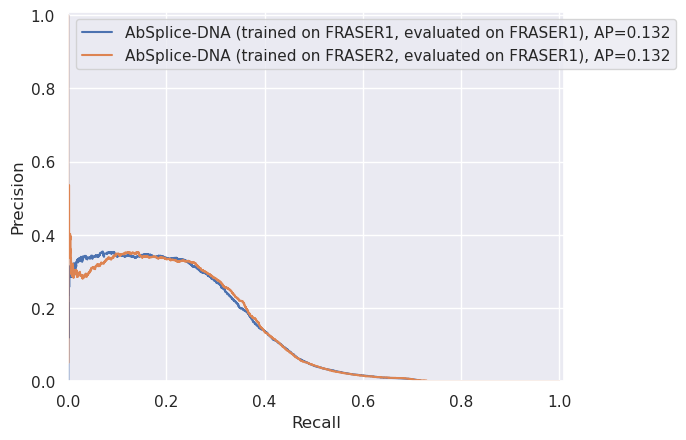

In [7]:
df_performance1, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict1,
)

In [8]:
model_dict2 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER2)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


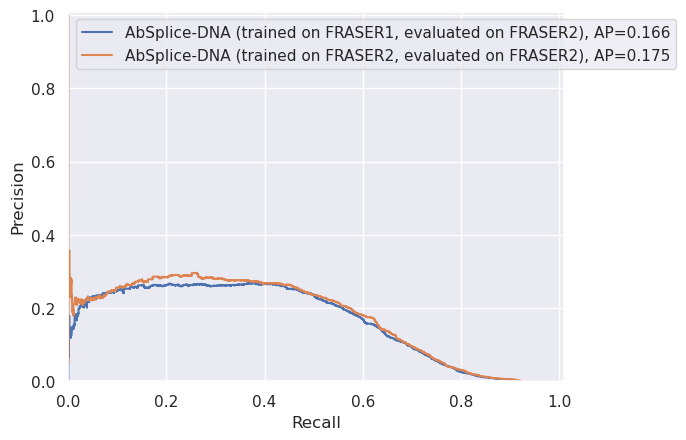

In [9]:
df_performance2, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [10]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [11]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_FRASER1_and_FRASER2_ground_truth.csv'), index=False)

### Performance across tissues

In [12]:
model_dict1 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER1)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 49/49 [03:18<00:00,  4.05s/it]


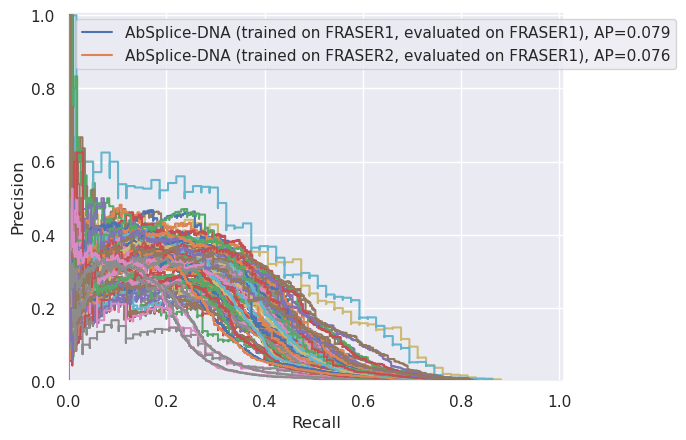

In [13]:
df_performance1 = []
for tissue in tqdm(tissues):
    _df = df_benchmark[df_benchmark['tissue'] == tissue]
    _df_performance1, performance = get_performance(
        df = _df, 
        outlier_column = 'outlier_fraser1', 
        model_dict = model_dict1,
    )
    _df_performance1['tissue'] = tissue
    df_performance1.append(_df_performance1)
df_performance1 = pd.concat(df_performance1)

In [14]:
model_dict2 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER2)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 49/49 [03:23<00:00,  4.15s/it]


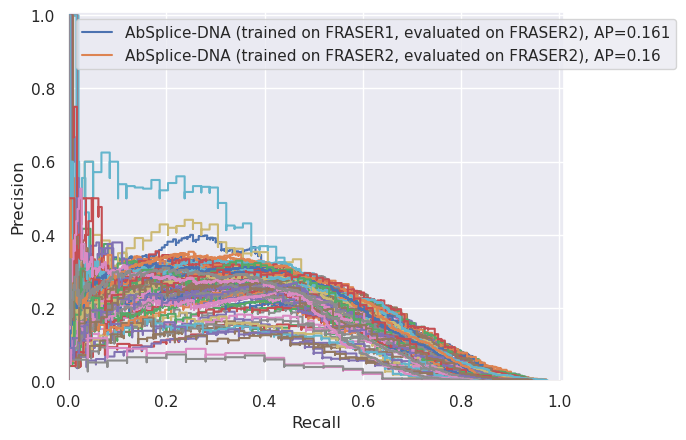

In [15]:
df_performance2 = []
for tissue in tqdm(tissues):
    _df = df_benchmark[df_benchmark['tissue'] == tissue]
    _df_performance2, performance = get_performance(
        df = _df, 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    _df_performance2['tissue'] = tissue
    df_performance2.append(_df_performance2)
df_performance2 = pd.concat(df_performance2)

In [16]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [17]:
df_performance = df_performance[[
    'model', 'aps', 'tissue'
]].drop_duplicates()

In [18]:
df_performance = df_performance.rename(columns={'aps': 'Average Precision Score'})

In [19]:
df_performance.to_csv(os.path.join(SAVE_DIR, 'pr_curve_FRASER1_and_FRASER2_ground_truth_boxplot.csv'), index=False)

## Signed features SpliceAI and Pangolin

In [6]:
model_dict = {
    'SpliceAI Delta Score': 'delta_score_spliceai', 
    'AbSplice-DNA (SpliceAI max score)': 'AbSplice_DNA_spliceai_fraser2',
    'AbSplice-DNA (Pangolin max score)': 'AbSplice_DNA_pangolin_binary',
    'Pangolin Score': 'pangolin_score',
    'AbSplice-DNA (Pangolin all scores, signed)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA (Pangolin max score, signed)': 'AbSplice_DNA_pangolin_signed_binary_modified_input',
    'AbSplice-DNA (SpliceAI all scores, signed)': 'AbSplice_DNA_spliceai_four_scores_signed_modified_input',
    'AbSplice-DNA (SpliceAI max score, signed)': 'AbSplice_DNA_spliceai_single_score_signed_modified_input',
}

100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


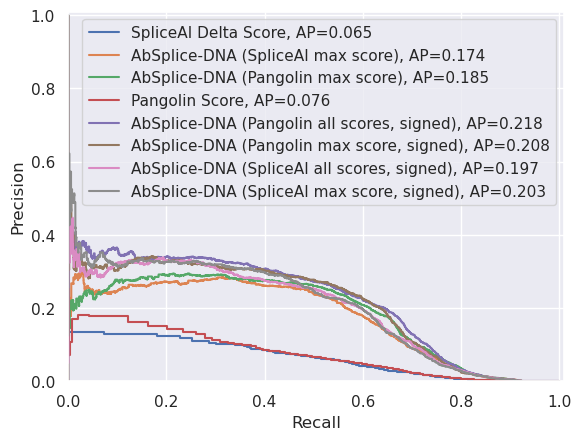

In [21]:
df_performance, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict,
)

In [22]:
df_performance.to_csv(os.path.join(SAVE_DIR, 'pr_curve_signed_features_SpliceAI_Pangolin.csv'), index=False)

100%|██████████| 49/49 [04:04<00:00,  4.99s/it]


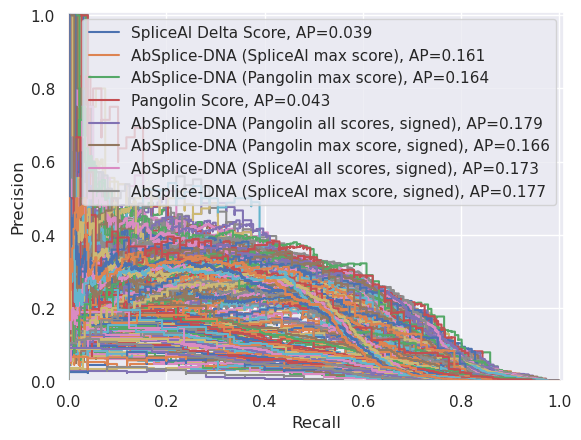

In [15]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)
df_all_performances = pd.concat(df_all_performances)

In [19]:
_df_box = df_all_performances[['model', 'aps', 'tissue']].drop_duplicates().set_index('model')

In [41]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (SpliceAI all scores, signed)', 
            model2='AbSplice-DNA (SpliceAI max score)')

Average precision improvement: 1.1208791208791211
Wilcoxon signed-rank test: statistic=1041.0000, p-value=3.254e-06


In [40]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (Pangolin all scores, signed)', 
            model2='AbSplice-DNA (SpliceAI all scores, signed)')

Average precision improvement: 1.0947357203751065
Wilcoxon signed-rank test: statistic=1121.0000, p-value=1.251e-08


## Continous median_n impact

In [42]:
model_dict2 = {
    'AbSplice-DNA (Pangolin all scores, binary)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA (Pangolin all scores, continuous)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input',
    'AbSplice-DNA (SpliceAI all scores, binary)': 'AbSplice_DNA_spliceai_fraser2',
    'AbSplice-DNA (SpliceAI all scores, continuous)': 'AbSplice_DNA_spliceai_median_n',
}

100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


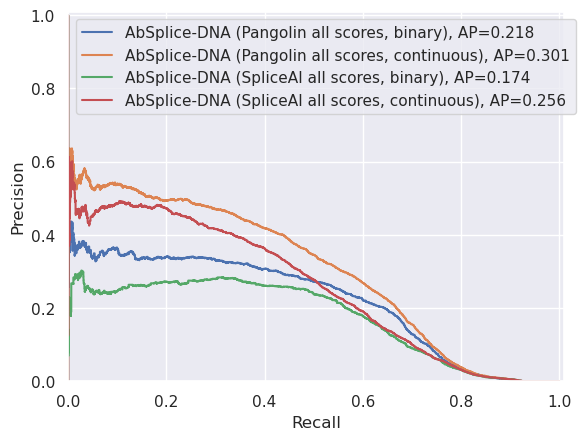

In [43]:
df_performance, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [25]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_continous_median_n_impact.csv'), index=False)

100%|██████████| 49/49 [03:31<00:00,  4.32s/it]


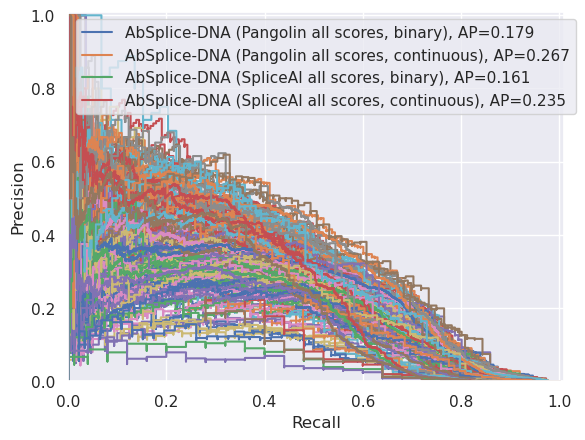

In [44]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)
df_all_performances = pd.concat(df_all_performances)

In [45]:
_df_box = df_all_performances[['model', 'aps', 'tissue']].drop_duplicates().set_index('model')

In [46]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (Pangolin all scores, continuous)', 
            model2='AbSplice-DNA (Pangolin all scores, binary)')

Average precision improvement: 1.4149712839482136
Wilcoxon signed-rank test: statistic=1225.0000, p-value=1.776e-15


## Final AbSplice2 model

In [26]:
model_dict1 = {
    'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
}

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


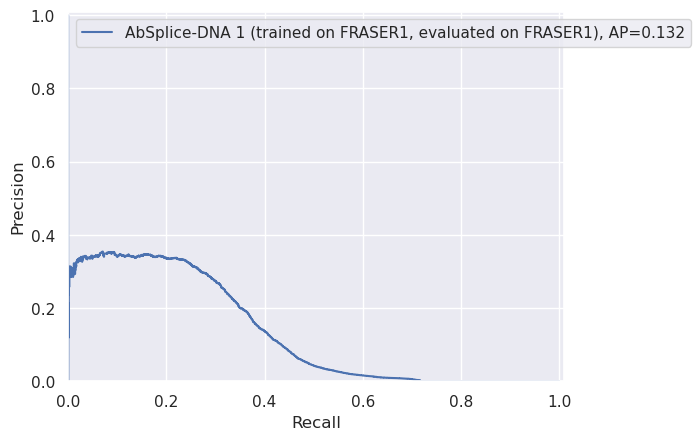

In [27]:
df_performance1, performance1 = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict1,
)

In [28]:
model_dict2 = {
    'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (SpliceAI -> Pangolin)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA 2': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input',
    'Pangolin': 'pangolin_score',
    'SpliceAI': 'delta_score_spliceai',
}

100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


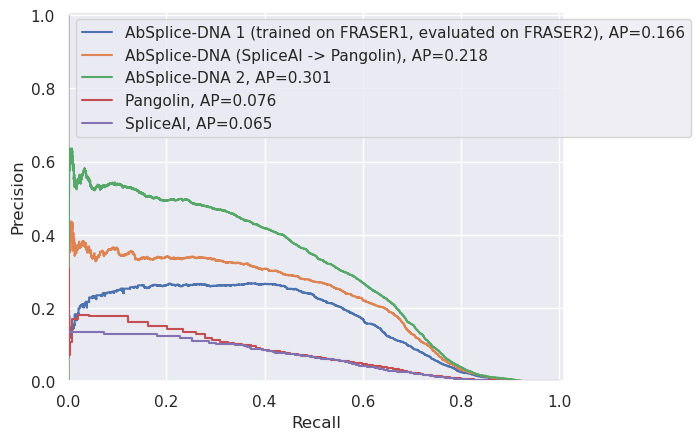

In [29]:
df_performance2, performance2 = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [30]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [31]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_final_absplice2_model.csv'), index=False)

### performance across tissues

100%|██████████| 49/49 [03:46<00:00,  4.62s/it]


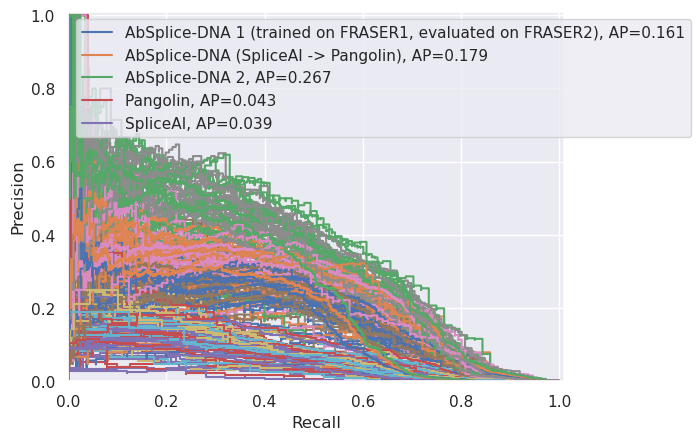

In [32]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)

100%|██████████| 49/49 [03:47<00:00,  4.63s/it]


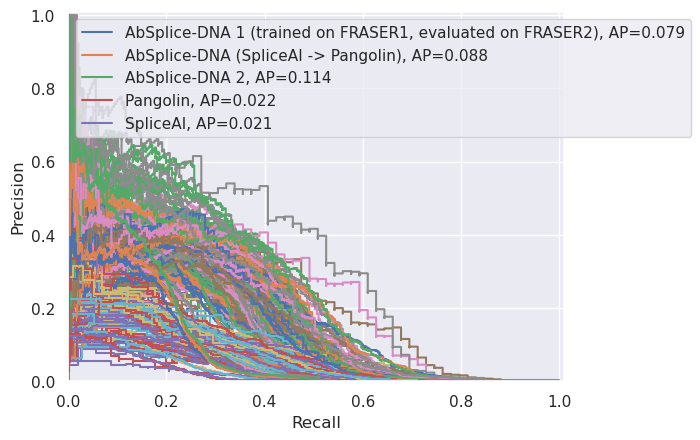

In [33]:
df_all_performances_fraser1 = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier_fraser1', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances_fraser1.append(df_performance2)
df_all_performances_fraser1 = pd.concat(df_all_performances_fraser1)

In [34]:
pd.concat(df_all_performances).to_csv(os.path.join(SAVE_DIR,  'pr_curve_for_all_GTEx_tissues.csv'), index=False)

In [35]:
df_all_performances_boxplot_fraser2 = pd.concat(df_all_performances)
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2[[
    'model', 'aps', 'tissue'
]].drop_duplicates()

In [36]:
df_all_performances_boxplot_fraser1 = df_all_performances_fraser1[[
    'model', 'aps', 'tissue'
]].drop_duplicates()
df_all_performances_boxplot_fraser1 = df_all_performances_boxplot_fraser1[df_all_performances_boxplot_fraser1['model'] == 'AbSplice1']
df_all_performances_boxplot_fraser1 = df_all_performances_boxplot_fraser1.replace('AbSplice1', 'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER1)')

In [37]:
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice1', 'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER2)')
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice1 (SpliceAI -> Pangolin)', 'AbSplice-DNA (SpliceAI -> Pangolin)')
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice2', 'AbSplice-DNA 2')

In [38]:
df_all_performances_boxplot = pd.concat([
    df_all_performances_boxplot_fraser1,
    df_all_performances_boxplot_fraser2
])

In [39]:
df_all_performances_boxplot = df_all_performances_boxplot.rename(columns={'aps': 'Average Precision Score'})

In [40]:
df_all_performances_boxplot.to_csv(os.path.join(SAVE_DIR,  'boxplot_all_tissues_GTEx.csv'), index=False)

### AbSplice-RNA

In [41]:
df_rna = pd.read_parquet(os.path.join(source_data, 'joined_benchmark_dna_rna.parquet'))

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


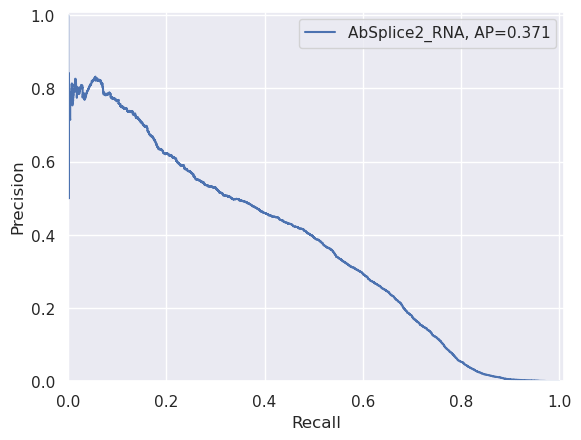

In [42]:
df_performance, performance = get_performance(
    df = df_rna, 
    outlier_column = 'outlier', 
    model_dict = {
        'AbSplice2_RNA': 'AbSplice_RNA_2_temporary',
    },
)

In [43]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_AbSplice_RNA.csv'), index=False)

100%|██████████| 49/49 [03:19<00:00,  4.06s/it]


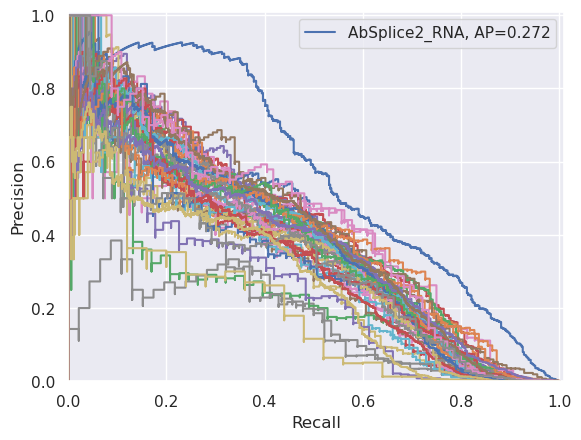

In [44]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_rna[df_rna['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = {
            'AbSplice2_RNA': 'AbSplice_RNA_2_temporary',
        },
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)

In [45]:
df_box = pd.concat(df_all_performances)[['model', 'aps', 'tissue']].drop_duplicates().rename(columns={'aps': 'Average Precision Score'})

In [46]:
df_box.to_csv(os.path.join(SAVE_DIR, 'boxplot_all_tissues_GTEx_AbSplice_RNA.csv'), index=False)

## Max aggregation decreases performance

In [47]:
model_dict = {
    'SpliceAI': 'delta_score_spliceai', 
    'Pangolin': 'pangolin_score',
    'AbSplice-DNA 1': 'AbSplice_DNA_published',
    'AbSplice-DNA 2': 'AbSplice_DNA_no_mmsplice_pangolin_tissue',

    'AbSplice DNA 2 (max all)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_max_all',
    'AbSplice DNA 1 (max all)': 'AbSplice_DNA_published_max_all',
    'AbSplice DNA 2 (max main tissues)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_main_tissue',
    'AbSplice DNA 2 (max dev tissues)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_main_tissue_kaessmann',
    'AbSplice DNA 1 (max main tissues)': 'AbSplice_DNA_published_main_tissue',
    'AbSplice DNA 1 (max dev tissues)': 'AbSplice_DNA_published_main_tissue_kaessmann',
}

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


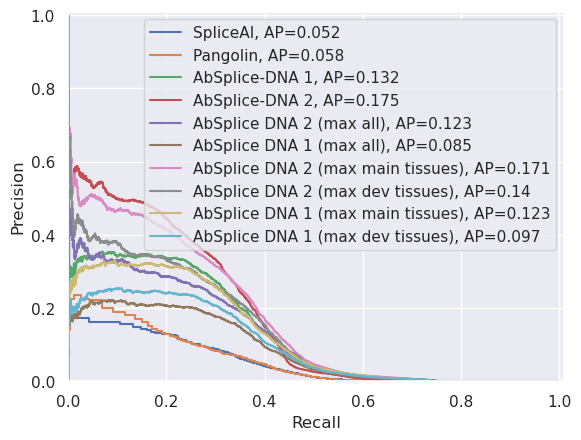

In [48]:
df_performance1, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict,
)

In [49]:
df_performance1['outlier'] = 'FRASER1'

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


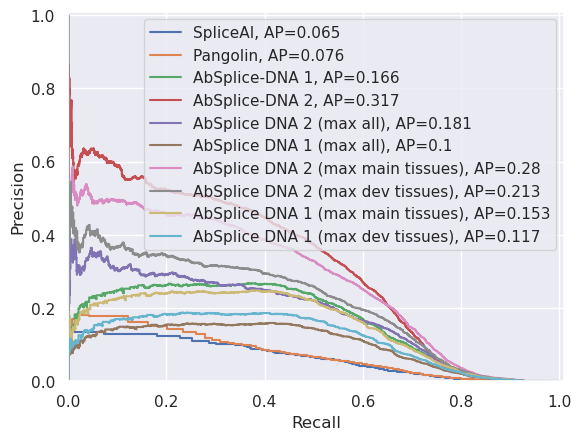

In [50]:
df_performance2, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict,
)

In [51]:
df_performance2['outlier'] = 'FRASER2'

In [52]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [53]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_max_aggregation_decreases_performance.csv'), index=False)

## Performance across gene expression values

In [54]:
model_dict = {
    'SpliceAI': 'delta_score_spliceai',
    'Pangolin': 'pangolin_score',
    'AbSplice-DNA 1': 'AbSplice_DNA_spliceai_modified_input',
    'AbSplice-DNA 2': 'AbSplice_DNA_no_mmsplice_pangolin_tissue',
    'AbSplice-DNA with gene TPM': 'AbSplice_DNA_pangolin_two_scores_gene_tpm',
}

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 10.11it/s]
1it [00:22, 22.69s/it]
100%|██████████| 5/5 [00:00<00:00, 44.56it/s]
2it [00:28, 12.77s/it]
100%|██████████| 5/5 [00:00<00:00, 25.81it/s]
3it [00:37, 11.24s/it]
100%|██████████| 5/5 [00:00<00:00, 23.80it/s]
4it [00:48, 10.96s/it]
100%|██████████| 5/5 [00:00<00:00, 24.62it/s]
5it [00:58, 10.57s/it]
100%|██████████| 5/5 [00:00<00:00, 48.20it/s]
6it [01:03, 10.58s/it]


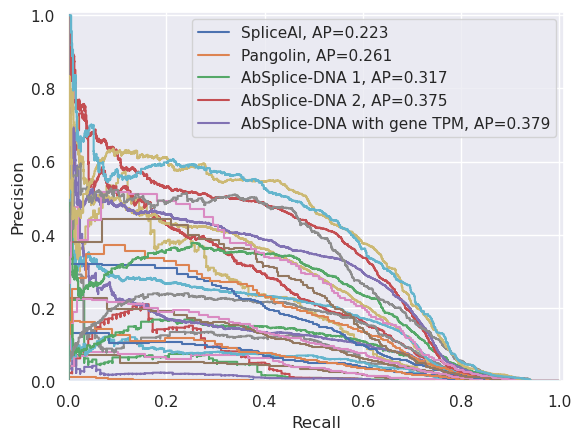

In [55]:
cutoffs = [
    (0, 3), (3, 5), 
    (5, 10), (10, 20), (20, 50), (50, np.inf)
]

df_performances = []
df_stats = []

for i, cutoff_pair in tqdm(enumerate(cutoffs)):
    low_cutoff, high_cutoff = cutoff_pair
    df_plot = df_benchmark[
        (df_benchmark['gene_tpm']>=low_cutoff)
        &
        (df_benchmark['gene_tpm']<high_cutoff)
    ].copy()
    df_performance, performance = get_performance(
        df = df_plot, 
        outlier_column = 'outlier', 
        model_dict = model_dict,
    )
    df_performance['cutoff_pair'] = f'{cutoff_pair}'
    df_performances.append(df_performance)

    df_stat = pd.DataFrame({
        'tpm_cutoff': f'{cutoff_pair}',
        'num_outliers': df_plot['outlier'].sum(),
    }, index=[0])
    df_stats.append(df_stat)
df_performances = pd.concat(df_performances)
df_stats = pd.concat(df_stats)

In [56]:
df_stats['tpm_cutoff_label'] = df_stats.apply(lambda df: f'TPM = {df["tpm_cutoff"]}, #outliers = {df["num_outliers"]}', axis=1)

In [57]:
df_performances.to_csv(os.path.join(SAVE_DIR,  'pr_curve_across_gene_expression_values.csv'), index=False)
df_stats.to_csv(os.path.join(SAVE_DIR,  'pr_curve_across_gene_expression_values_stats.csv'), index=False)

# Feature importance

## FRASER1 vs FRASER2

In [58]:
ebm_model_fraser1_path = '/data/ceph/hdd/project/node_01/absplice/AbSplice_analysis/data/results/gtex_v8/splicing_predictions/raw_pred/absplice/absplice_training/whole_GTEx/classifier=interpretml/delta_logit_psi__delta_psi__delta_score__splice_site_is_expressed/abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
ebm_model_fraser2_path = '/data/ceph/hdd/project/node_01/absplice/AbSplice_2_0/training/raw_pred/old_conda/whole_GTEx/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__delta_score__splice_site_is_expressed/abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'

In [59]:
# Load the model from the pkl file
with open(ebm_model_fraser1_path, "rb") as file:
    ebm_model_fraser1 = pickle.load(file)

feature_names = [x for x in ebm_model_fraser1.feature_names if ' x ' not in x]
feature_indices = [ebm_model_fraser1.feature_names.index(x) for x in feature_names]

x_list_fraser1 = []
y_list_fraser1 = []

for feature_idx in feature_indices:
    try:
        x_list_fraser1.append(ebm_model_fraser1.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_fraser1.append(ebm_model_fraser1.additive_terms_[feature_idx])
    except:
        pass

In [60]:
# Load the model from the pkl file
with open(ebm_model_fraser2_path, "rb") as file:
    ebm_model_fraser2 = pickle.load(file)

feature_names = [x for x in ebm_model_fraser2.feature_names if ' x ' not in x]
feature_indices = [ebm_model_fraser2.feature_names.index(x) for x in feature_names]

x_list_fraser2 = []
y_list_fraser2 = []

for feature_idx in feature_indices:
    try:
        x_list_fraser2.append(ebm_model_fraser2.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_fraser2.append(ebm_model_fraser2.additive_terms_[feature_idx])
    except:
        pass

In [61]:
epsilon = 0.001
x_list_fraser1.append([10-epsilon, 10+epsilon])

epsilon = 0.001
x_list_fraser2.append([10-epsilon, 10+epsilon])

In [62]:
# Define custom x-axis limits for each feature (modify these as needed)
x_ranges = {
    "delta_logit_psi": (-5, 5),
    "delta_psi": (-1, 1),
    "delta_score": (0, 1),
    "gain_score": (0, 1),
    "loss_score": (-1, 0),
    "median_n": (0, 100),
    "splice_site_is_expressed": (0, 100),
}

In [63]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_fraser2, y_list_fraser2):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'splice_site_is_expressed':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_fraser2 = pd.DataFrame(data)
df_plot_fraser2['model'] = 'fraser2'

In [64]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_fraser1, y_list_fraser1):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'splice_site_is_expressed':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_fraser1 = pd.DataFrame(data)
df_plot_fraser1['model'] = 'fraser1'

In [65]:
df_plot = pd.concat([
    df_plot_fraser2,
    df_plot_fraser1
])

In [66]:
df_plot = df_plot.rename(columns={'x': 'Feature value', 'y': 'Contribution Score'})

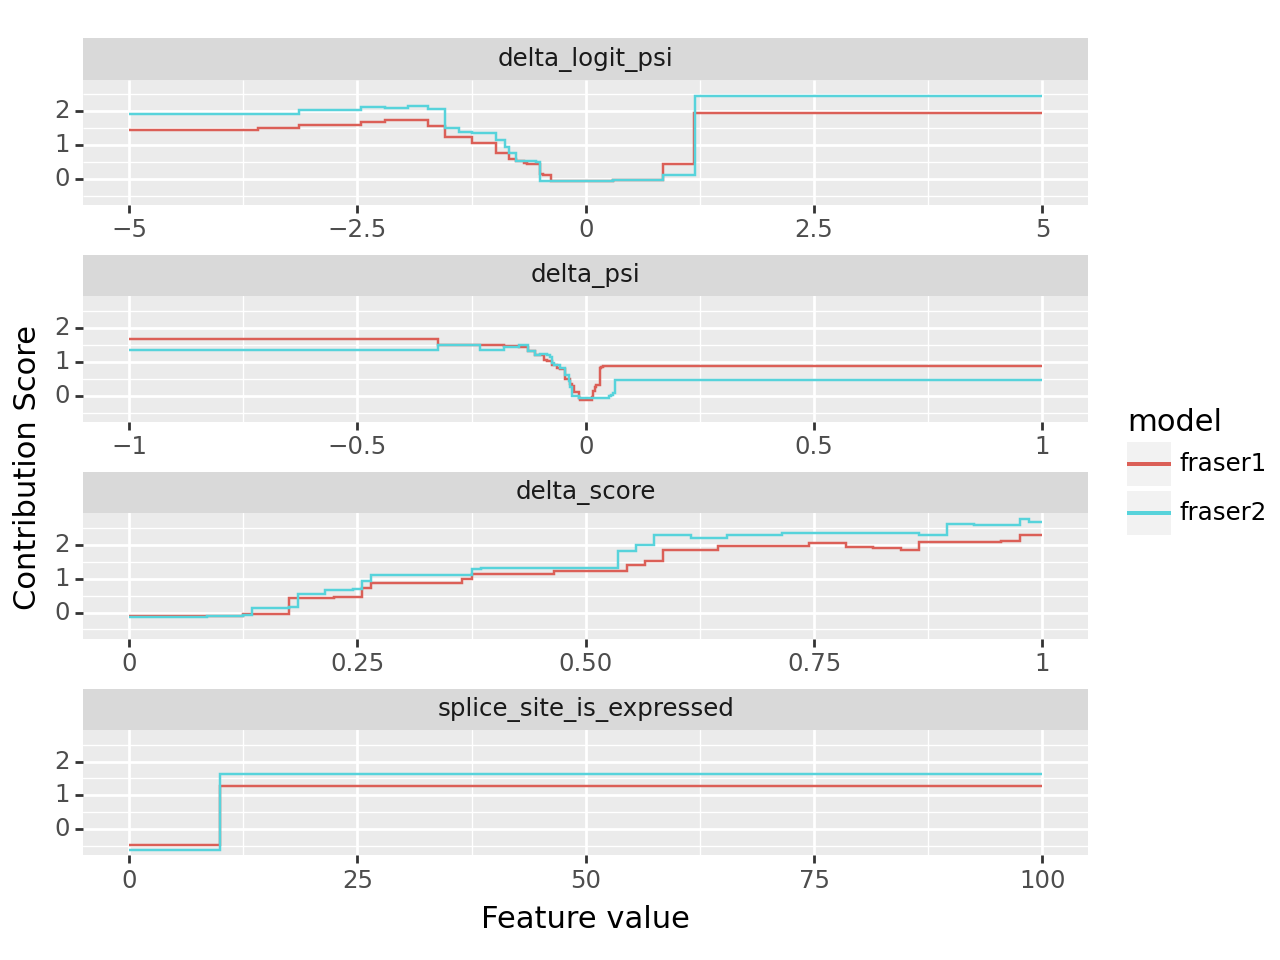

In [67]:
# Define global y-limits (modify as needed)
y_min, y_max = df_plot["Contribution Score"].min(), df_plot["Contribution Score"].max()

# Plot
plot = (
    ggplot(df_plot, aes(x='Feature value', y='Contribution Score', color='model')) +
    geom_step(direction='hv') +
    facet_wrap('~feature', ncol=1, scales='free_x') +  # Single-column layout, x free
    theme(subplots_adjust={'hspace': 0.3}) +  # Adjust spacing between plots
    ylim(y_min, y_max)  # Fix the y-axis range
)

print(plot)

In [68]:
df_plot.to_csv(os.path.join(SAVE_DIR,  'feature_importance_fraser1_and_fraser2.csv'), index=False)

## Binary to continous median_n

In [115]:
root_path_models = '../data/_TMP/raw_pred/old_conda/whole_GTEx/added_positive_delta_psi_samples/classifier=interpretml'
ebm_model_binary_path = os.path.join(
    root_path_models, 
    'delta_logit_psi__delta_psi__gain_score__loss_score__splice_site_is_expressed',
    'abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
)
ebm_model_continous_path = os.path.join(
    root_path_models, 
    'delta_logit_psi__delta_psi__gain_score__loss_score__median_n',
    'abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
)

In [116]:
# Load the model from the pkl file
with open(ebm_model_binary_path, "rb") as file:
    ebm_model_binary = pickle.load(file)

feature_names = [x for x in ebm_model_binary.feature_names if ' x ' not in x]
feature_indices = [ebm_model_binary.feature_names.index(x) for x in feature_names]

x_list_binary = []
y_list_binary = []

for feature_idx in feature_indices:
    try:
        x_list_binary.append(ebm_model_binary.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_binary.append(ebm_model_binary.additive_terms_[feature_idx])
    except:
        pass

In [117]:
# Load the model from the pkl file
with open(ebm_model_continous_path, "rb") as file:
    ebm_model_continous = pickle.load(file)

feature_names = [x for x in ebm_model_continous.feature_names if ' x ' not in x]
feature_indices = [ebm_model_continous.feature_names.index(x) for x in feature_names]

x_list_continous = []
y_list_continous = []

for feature_idx in feature_indices:
    try:
        x_list_continous.append(ebm_model_continous.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_continous.append(ebm_model_continous.additive_terms_[feature_idx])
    except:
        pass

In [118]:
epsilon = 0.001
x_list_binary.append([10-epsilon, 10+epsilon])

In [119]:
# Define custom x-axis limits for each feature (modify these as needed)
x_ranges = {
    "delta_logit_psi": (-2, 2),
    "delta_psi": (-1, 1),
    "delta_score": (0, 1),
    "gain_score": (0, 1),
    "loss_score": (-1, 0),
    "median_n": (0, 200),
}

In [120]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_continous, y_list_continous):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_continous = pd.DataFrame(data)
df_plot_continous['model'] = 'continous'

In [121]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_binary, y_list_binary):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'median_n':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_binary = pd.DataFrame(data)
df_plot_binary['model'] = 'binary'

In [122]:
df_plot = pd.concat([
    df_plot_continous,
    df_plot_binary
])

In [123]:
df_plot = df_plot.rename(columns={'x': 'score_value', 'y': 'Contribution Score'})

In [130]:
p9.options.figure_size = (10, 5)

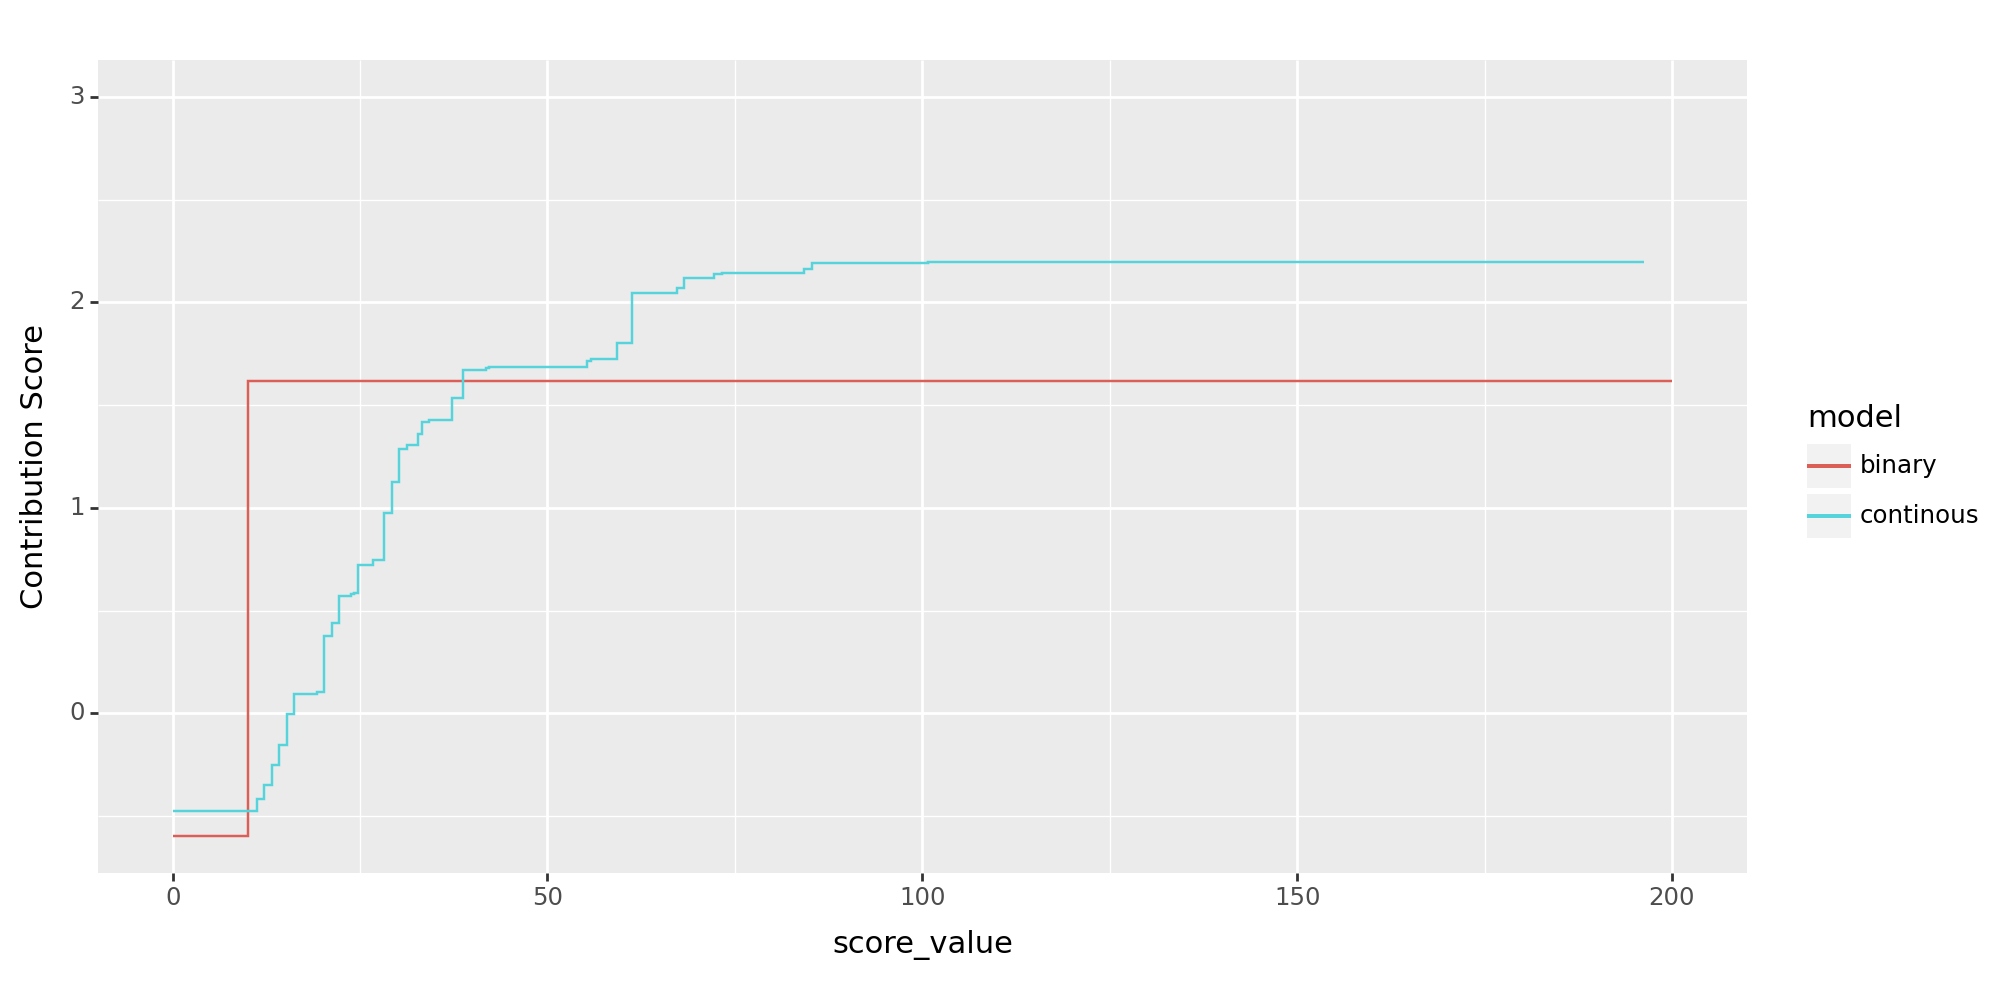

In [131]:
# Plot
plot = (
    ggplot(df_plot[df_plot['feature'] == 'median_n'], aes(x='score_value', y='Contribution Score', color='model')) +
    geom_step(direction='hv') +
    # facet_wrap('~feature', ncol=1, scales='free_x') +  # Single-column layout, x free
    theme(subplots_adjust={'hspace': 0.3}) +  # Adjust spacing between plots
    ylim(y_min, 3)  # Fix the y-axis range
)

print(plot)

In [80]:
df_plot.to_csv(os.path.join(SAVE_DIR,  'feature_importance_binary_and_continous_splice_site_usage.csv'), index=False)

### reranking of intermediate median_n values in AbSplice

In [81]:
df_binary = pd.read_parquet("../../../AbSplice2_analysis/workflow/data/_TMP/raw_pred/old_conda/5_fold_crossval/save_samples/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__gain_score__loss_score__splice_site_is_expressed/abs_features=False/results_all.parquet")
df_continous = pd.read_parquet("../../../AbSplice2_analysis/workflow/data/_TMP/raw_pred/old_conda/5_fold_crossval/save_samples/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__gain_score__loss_score__median_n/abs_features=False/results_all.parquet")

In [82]:
df_binary = df_binary.rename(columns={'y_pred': 'AbSplice_binary'})
df_continous = df_continous.rename(columns={'y_pred': 'AbSplice_continous'})

In [83]:
join_index = ['variant', 'gene_id', 'sample', 'tissue', 'y_test']

In [84]:
df_total = df_binary.set_index(join_index)[['AbSplice_binary']].join(
    df_continous.set_index(join_index)[['AbSplice_continous', 'median_n']]
).reset_index()

In [85]:
num_outliers = df_total[df_total['y_test'] == 1].shape[0]

In [86]:
df_sampled = pd.concat([
    df_total[df_total['y_test'] == 1],
    df_total[df_total['y_test'] == 0].sample(100*num_outliers),
])

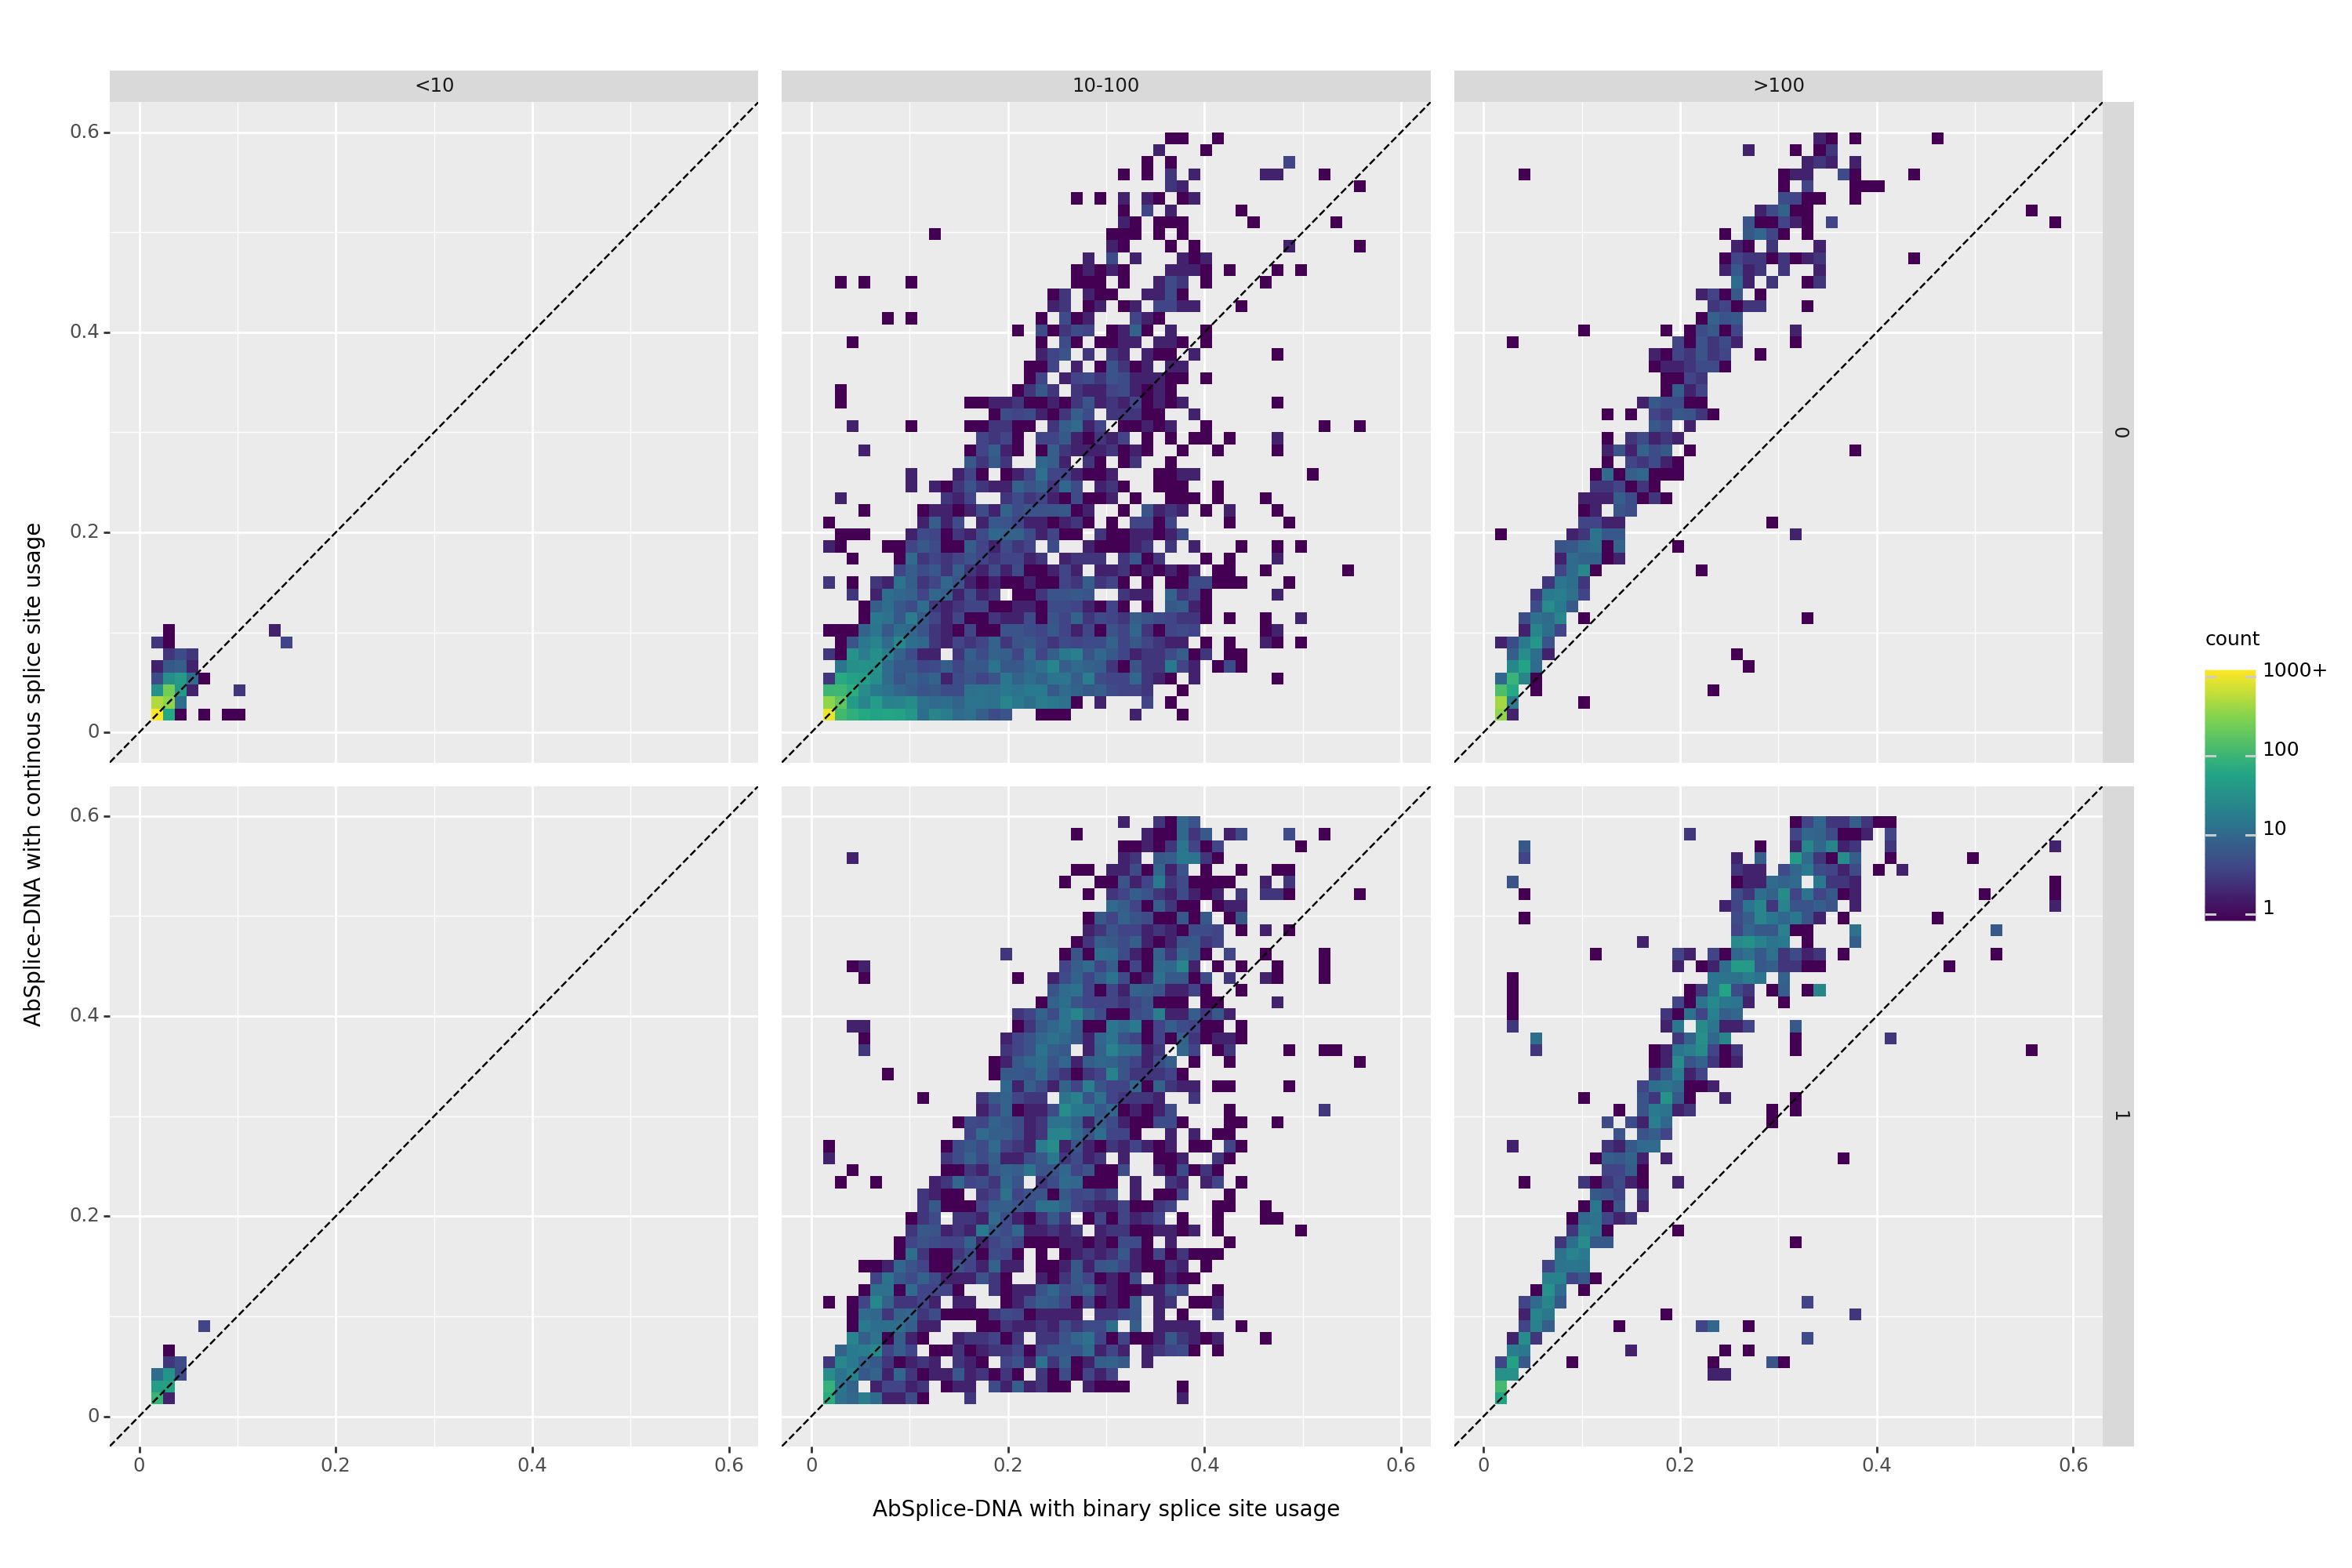

<Figure Size: (1500 x 1000)>

In [87]:
df_sampled['median_n_category'] = pd.cut(df_sampled['median_n'], bins=[-float('inf'), 10, 100, float('inf')], labels=['<10', '10-100', '>100'])
df_plot = df_sampled.copy()

# Set figure size
scale = 1
p9.options.figure_size = (15 * scale, 10 * scale)

# Define axis limits
min_val = min(df_plot['AbSplice_binary'].min(), df_plot['AbSplice_continous'].min())
max_val = max(df_plot['AbSplice_binary'].max(), df_plot['AbSplice_continous'].max())
max_val = 0.6  # Adjusted manually

# Set max count value for color mapping
max_count = 1000  # Values above this will be shown in the same color

# Create the plot
p = (
    p9.ggplot(df_plot, p9.aes(
        x='AbSplice_binary', 
        y='AbSplice_continous'
    )) 
    + p9.geom_bin2d(bins=50, raster=True)  # Increase bins for finer granularity
    + p9.scale_fill_gradientn(
        colors=[cm.viridis(i) for i in np.linspace(0, 1, 6)],  # Full Viridis range
        trans="log10",
        limits=(1, max_count),  # Clip color scale at max_count
        breaks=[1, 10, 100, 1000],  # Adjust color scale breaks
        labels=["1", "10", "100", "1000+"],  # Readable labels
    )
    + p9.geom_abline(slope=1, intercept=0, linetype="dashed", color="black")  # Diagonal reference line
    + p9.facet_grid('y_test ~ median_n_category')  # Facet by outlier category and median_n_category
    + p9.lims(x=(min_val, max_val), y=(min_val, max_val))  # Ensure equal scaling
    + p9.labs(x="AbSplice-DNA with binary splice site usage", y="AbSplice-DNA with continous splice site usage")  # Custom axis labels
    + p9.theme(
        legend_text=p9.element_text(size=9),
        legend_title=p9.element_text(size=9),
        axis_title=p9.element_text(size=10)
    )
)

p

In [88]:
df_sampled.to_csv(os.path.join(SAVE_DIR,  'median_n_reranking_absplice_scores.csv'), index=False)

## AbExp performance

In [47]:
df = pd.read_parquet('../data/_TMP2/gtex_v8_old_dna_newAbSpliceBenchmark/predict_folds/subset=dna_only/plots/compare_results.py@13_AbSplice2/performance.tissue.parquet')

In [48]:
chosen_models = [
    'AbSplice',
    'AbSplice2',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+SV+dups (AbExp)',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice2+Enformer+SV+dups (AbExp)',
]

In [49]:
model_name_map = {
    'AbSplice': 'AbSplice1',
    'AbSplice2': 'AbSplice2',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+SV+dups (AbExp)': 'AbExp \n(AbSplice1)',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice2+Enformer+SV+dups (AbExp)': 'AbExp \n(AbSplice2)',
}

In [50]:
sorted_models = (
    df.groupby('model')['auc'].median()
    .sort_values(ascending=False)
    .index
)

df['model_name'] = pd.Categorical(
    df['model'].map(model_name_map),
    categories=[model_name_map[m] for m in sorted_models if m in model_name_map],
    ordered=True
)

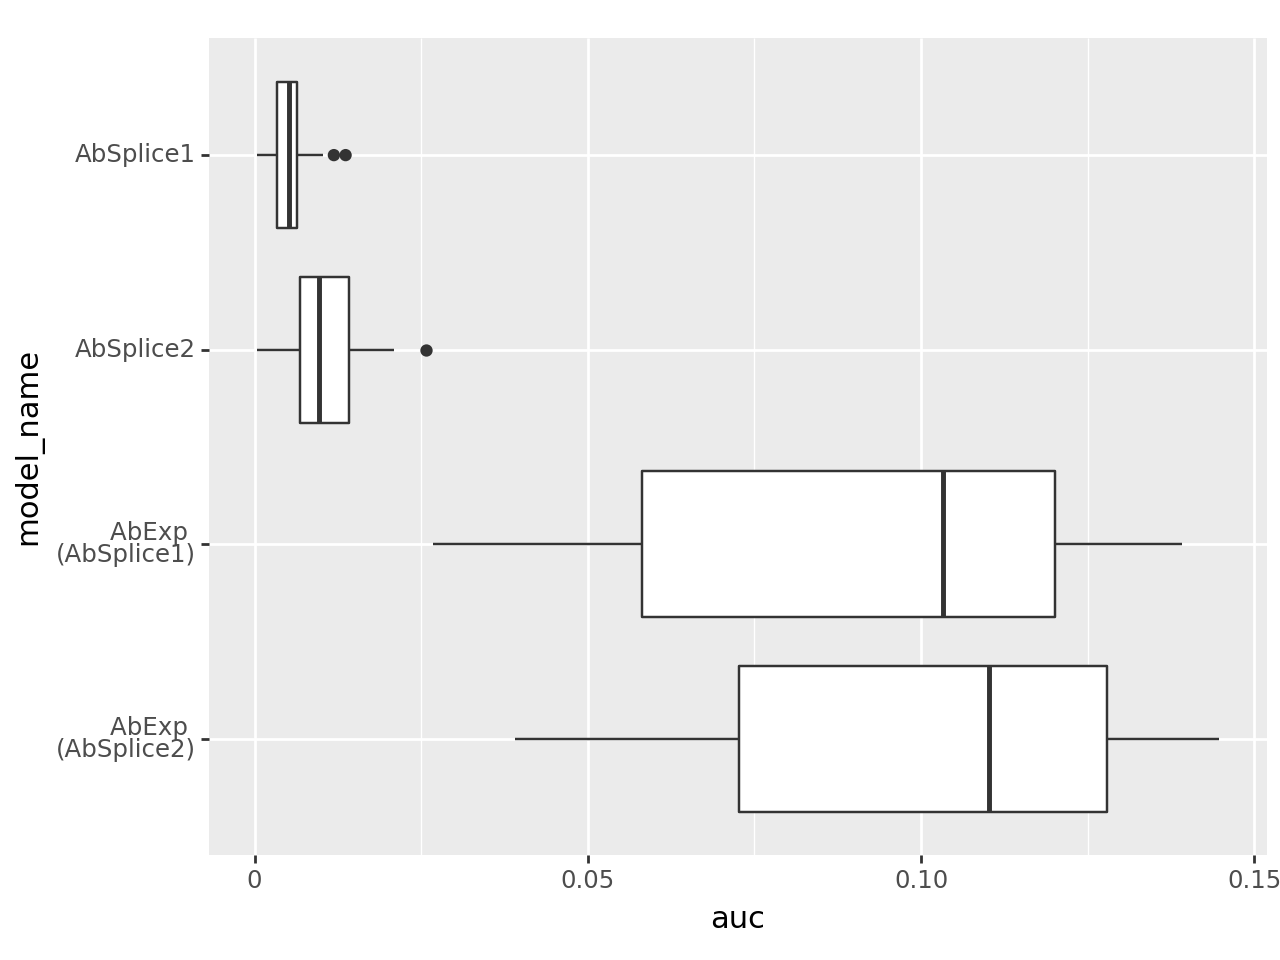

<Figure Size: (640 x 480)>

In [51]:
(
    ggplot(df[df['model'].isin(chosen_models)], aes(y='auc', x='model_name'))
    + geom_boxplot()
    + coord_flip()
)

In [58]:
_df_box = df[['model_name', 'tissue', 'auc']].drop_duplicates().rename(columns={'auc': 'aps'}).set_index('model_name')

In [64]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice2', 
            model2='AbSplice1')

Average precision improvement: 1.936059064481064
Wilcoxon signed-rank test: statistic=353.0000, p-value=6.735e-06


In [67]:
_,_ = compare_aps(_df_box, 
            model1='AbExp \n(AbSplice2)', 
            model2='AbExp \n(AbSplice1)',
            alternative='greater')

Average precision improvement: 1.067746267784874
Wilcoxon signed-rank test: statistic=319.0000, p-value=0.0005658


# Developmental variant

## devAS distribution across LOEUF deciles

In [68]:
df_loeuf = pd.read_parquet('../data/resources/common/loeuf_scores_with_expressed_tissues.parquet').reset_index()

In [69]:
df_loeuf = df_loeuf[
    ~df_loeuf['LOEUF_decile'].isna()
]

In [70]:
df_loeuf['LOEUF_decile'] = df_loeuf['LOEUF_decile'] / 10

In [71]:
df_loeuf['LOEUF_decile'] = df_loeuf['LOEUF_decile'].astype(int) + 1

Supplementary Data 9. Table contains all segments from all species that passed thresholds in at least one organ. The first seven columns give the segment unique ID, Ensembl ID of the genes that host the segment (if available), genome coordinates of the segment and segment type. CE. cassette exon; AA, alternative acceptor site; AD, alternative donor site; RI, retained intron. The next 21 columns provide the developmental patterns. ‘-’, segment did not pass the thresholds in a given organ; ‘n’, segment is not devAS; ‘u’, ‘d’, ‘ud’, ‘du’. denote up, down, up–down and down–up patterns, respectively. The dPSI and Benjamini–Hochberg (BH)-adjusted P values (segments that didn’t pass thresholds are marked by NA) for all seven organs.

In [72]:
sup_09_seg_above_thresh = pd.read_csv('../data/resources/devAbSplice/Supplementary_Data_9.csv')

In [73]:
sup_09_seg_above_thresh = sup_09_seg_above_thresh[
    sup_09_seg_above_thresh['seg.id'].str.contains('hum.')
].drop(columns='Unnamed: 0')

### start 1-based

In [74]:
sup_09_seg_above_thresh['start'] = sup_09_seg_above_thresh['start'] - 1

In [75]:
def convert_strand(strand):
    if strand == -1:
        return '-'
    elif strand == 1:
        return '+'
    else:
        print('missin')
        raise KeyError()

In [76]:
def splice_site_start(df, pos='start'):
    return str(df['Chromosome']) + ':' + str(df[pos]) + ':' + str(df['Strand'])

In [77]:
def get_plot_data(df_devAS):
    df_devAS = df_devAS.rename(columns={
        'chr_id': 'Chromosome',
        'strand': 'Strand'
    })
    df_devAS['Chromosome'] = df_devAS['Chromosome'].apply(lambda df: 'chr' + str(df))
    df_devAS['Strand'] = df_devAS.apply(lambda df: convert_strand(df['Strand']), axis=1)
    
    df_devAS['start_splice_site'] = df_devAS.apply(lambda df: splice_site_start(df, pos='start'), axis=1)
    df_devAS['stop_splice_site'] = df_devAS.apply(lambda df: splice_site_start(df, pos='stop'), axis=1)
    
    df_devAS_all = df_devAS.copy()
    
    df_devAS_all = df_devAS_all[
        ~df_devAS_all['ens_id'].isna()
    ]
    
    df_devAS_all['gene_id'] = df_devAS_all.apply(lambda df: df['ens_id'].split(','), axis=1)
    
    df_devAS_all = df_devAS_all.explode('gene_id')
    
    df_devAS_all['devAS'] = True
    df_devAS_join = df_devAS_all[['gene_id', 'devAS']].drop_duplicates()
    
    df_loeuf_devAS = df_loeuf.set_index('gene_id').join(df_devAS_join.set_index('gene_id')[['devAS']]).reset_index()
    df_loeuf_devAS['devAS'] = df_loeuf_devAS['devAS'].fillna(False)
    df_loeuf_devAS = df_loeuf_devAS[['gene_id', 'LOEUF_decile', 'devAS']].drop_duplicates()

    print(len(set(df_devAS_join['gene_id'])))
    return df_loeuf_devAS

In [78]:
def plot_loeuf_data(df_loeuf_devAS):
    plot = (
        ggplot(df_loeuf_devAS, aes(x='LOEUF_decile', fill='devAS'))
        # + geom_bar(stat="count", color="black", alpha=0.7, position=position_dodge(width=0.8), width=0.6)
        + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
        + theme_light()
        + labs(
            # title="devAS are enriched for low LOEUF deciles", 
            x="LOEUF decile", 
            y="Number of genes",
            fill='Gene contains devAS'
        )
        + scale_x_continuous(breaks=range(1, 11))
        + scale_fill_manual(values=["#b2182b", "#404040"])  # Custom colors similar to the plot
        + theme(
            axis_title_x=element_text(size=12),
            axis_title_y=element_text(size=12),
            # legend_title='Gene contains devAS',
            legend_position="right"
        )
    )
    print(plot)

In [79]:
def plot_loeuf_data(df_loeuf_devAS, file_path=None, fontsize=12):
    plot = (
        ggplot(df_loeuf_devAS, aes(x='LOEUF_decile', fill='devAS'))
        + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
        + theme_light()
        + labs(
            x="LOEUF decile", 
            y="Number of genes",
            fill='Gene \ncontains \ndevAS'
        )
        + scale_x_continuous(breaks=range(1, 11))
        + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
        + theme(
            axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
            axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
            legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
            legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
            panel_grid_major=element_blank(),  # Remove major grid lines
            panel_grid_minor=element_blank(),  # Remove minor grid lines
            panel_background=element_blank(),  # Remove panel background
            plot_background=element_blank(),  # Make the plot background transparent
            legend_background=element_blank()  # Transparent legend background
        )
    )
    
    # Save the plot if file_path is provided
    if file_path:
        plot.save(file_path, format='svg', dpi=300, background="transparent", verbose=False)  # Save with 300 DPI
        print(f"Plot saved as {file_path}")
    
    # Print plot to display
    print(plot)

### All tissues

In [80]:
# pattern needs to be everything except 'n' or '-'
pattern_cols = [col for col in sup_09_seg_above_thresh.columns if col.startswith('pattern.')]
# Check for each row if all values in 'pattern.' columns are 'n' or '-'
rows_with_n_or_dash = sup_09_seg_above_thresh[pattern_cols].apply(lambda x: all(val in ['n', '-'] for val in x), axis=1)
df_devAS = sup_09_seg_above_thresh[~rows_with_n_or_dash]

In [81]:
df_devAS.shape

(27954, 28)

In [82]:
df_loeuf_devAS = get_plot_data(df_devAS)

8921


In [109]:
df_loeuf_devAS.to_csv(os.path.join(SAVE_DIR, 'LOUEF_devAS_distribution.csv'), index=False)

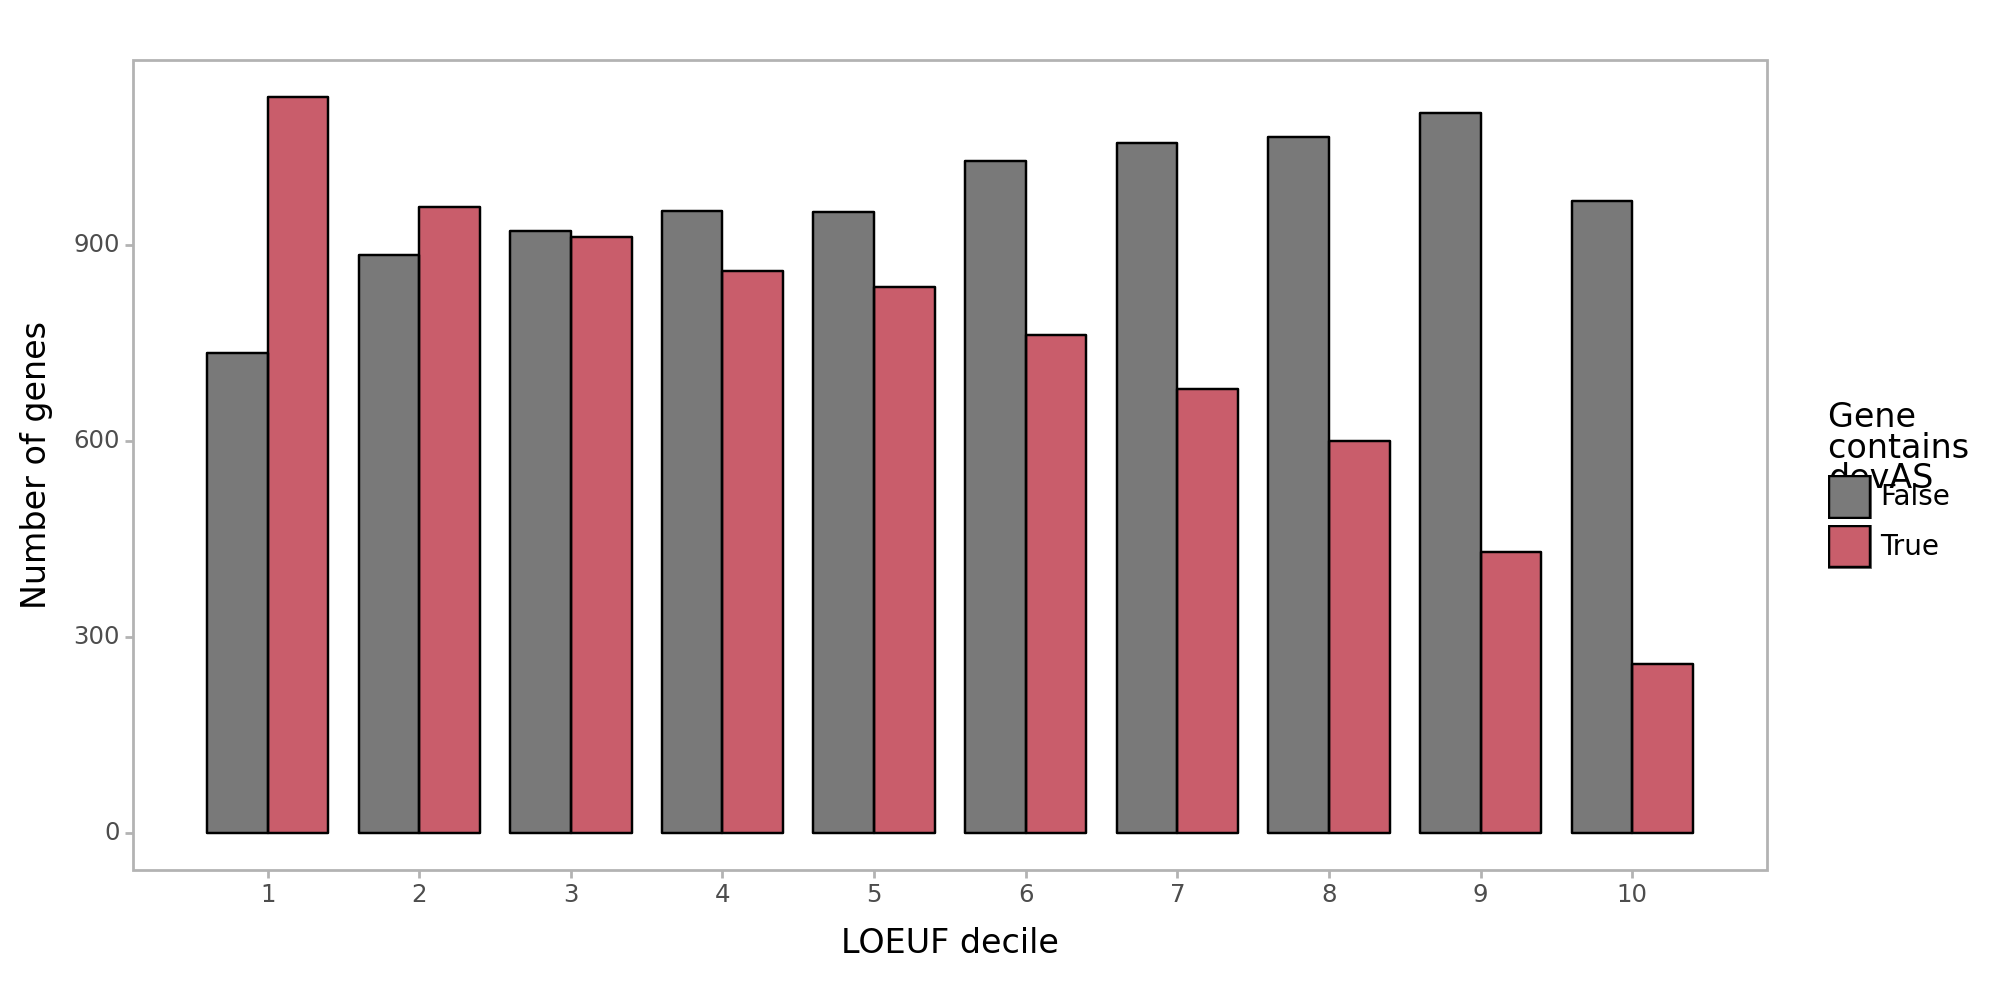

In [133]:
plot_loeuf_data(
    df_loeuf_devAS
)

In [119]:
from scipy.stats import fisher_exact

# Group deciles
def group_lof_tolerance(decile):
    if decile in [1, 2, 3]:
        return 'intolerant'
    elif decile in [8, 9, 10]:
        return 'tolerant'
    else:
        return 'middle'
        
def LOEUF_decile_stat_test(df, col='devAS'):
    df['lof_group'] = df['LOEUF_decile'].apply(group_lof_tolerance)
    
    # Filter to only "intolerant" vs "tolerant"
    df_filtered = df[df['lof_group'].isin(['intolerant', 'tolerant'])]
    
    # Create contingency table
    contingency = pd.crosstab(df_filtered['lof_group'], df_filtered[col])
    
    # Reorder to ensure format: [[intolerant True, intolerant False], [tolerant True, tolerant False]]
    table = [
        [contingency.loc['intolerant', True], contingency.loc['intolerant', False]],
        [contingency.loc['tolerant', True], contingency.loc['tolerant', False]]
    ]
    
    # Fisher's exact test
    oddsratio, p_value = fisher_exact(table)

    print(contingency)
    print(f"Odds ratio: {oddsratio:.2f}")
    print(f"P-value: {p_value:.2e}")

In [120]:
LOEUF_decile_stat_test(df_loeuf_devAS, col='devAS')

devAS       False  True 
lof_group               
intolerant   2541   2998
tolerant     3134   1289
Odds ratio: 2.87
P-value: 1.52e-140


## Predictions higher in dev than GTEx

In [91]:
tissues = [
    'brain',
    'cerebellum',
    'heart',
    'testis',
    'ovary',
    'liver',
    'kidney',
]

### per variant

In [92]:
high_cutoff = 0.2
low_cutoff = 0.05
model_name = 'model_27'
delta_t = 1

early_col = 'max_early'
late_col = 'max_GTEx'
# late_col = 'max_late'

df_comb = []
for chrom in tqdm([f'chr{x}' for x in range(1,23)]):
    _df = pd.read_parquet(os.path.join(
            '../../../AbSplice_analysis/workflow/data/results/devAbSplice/',
            f'splicing_predictions/max_preds/absplice2_NEW/{model_name}/max_preds_dev_GTEx/delta_t={delta_t}/{chrom}_AbSplice_DNA.parquet'))
    df_comb.append(_df)
df_comb = pd.concat(df_comb)

df_num_vars = []
tissue_vars = {}
for tissue in tissues:
    _df_tissue = df_comb[
        (df_comb[f'{tissue}_{early_col}'] >= high_cutoff)
        & (df_comb[f'{tissue}_{late_col}'] < low_cutoff)
    ]
    _df_tissue['variant'] = _df_tissue.progress_apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    df_num_vars.append(pd.DataFrame({
        'tissue': tissue,
        'num_vars': len(set(_df_tissue.set_index(['variant', 'gene_id']).index))
    }, index=[0]))
    tissue_vars[tissue] = sorted(set(_df_tissue.set_index(['variant', 'gene_id']).index))

if late_col == 'max_GTEx':
    _df_all_tissues = df_comb[
        (df_comb[early_col] >= high_cutoff)
        & (df_comb['max_all_GTEx'] < low_cutoff)
    ]
else:
    _df_all_tissues = df_comb[
        (df_comb[early_col] >= high_cutoff)
        & (df_comb[late_col] < low_cutoff)
    ]
_df_all_tissues['variant'] = _df_all_tissues.progress_apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
df_num_vars.append(pd.DataFrame({
    'tissue': 'all_tissues',
    'num_vars': len(set(_df_all_tissues.set_index(['variant', 'gene_id']).index))
}, index=[0]))
df_num_vars = pd.concat(df_num_vars)
df_num_vars = df_num_vars.sort_values(by='num_vars', ascending=False)

100%|██████████| 1811/1811 [00:00<00:00, 82132.77it/s]


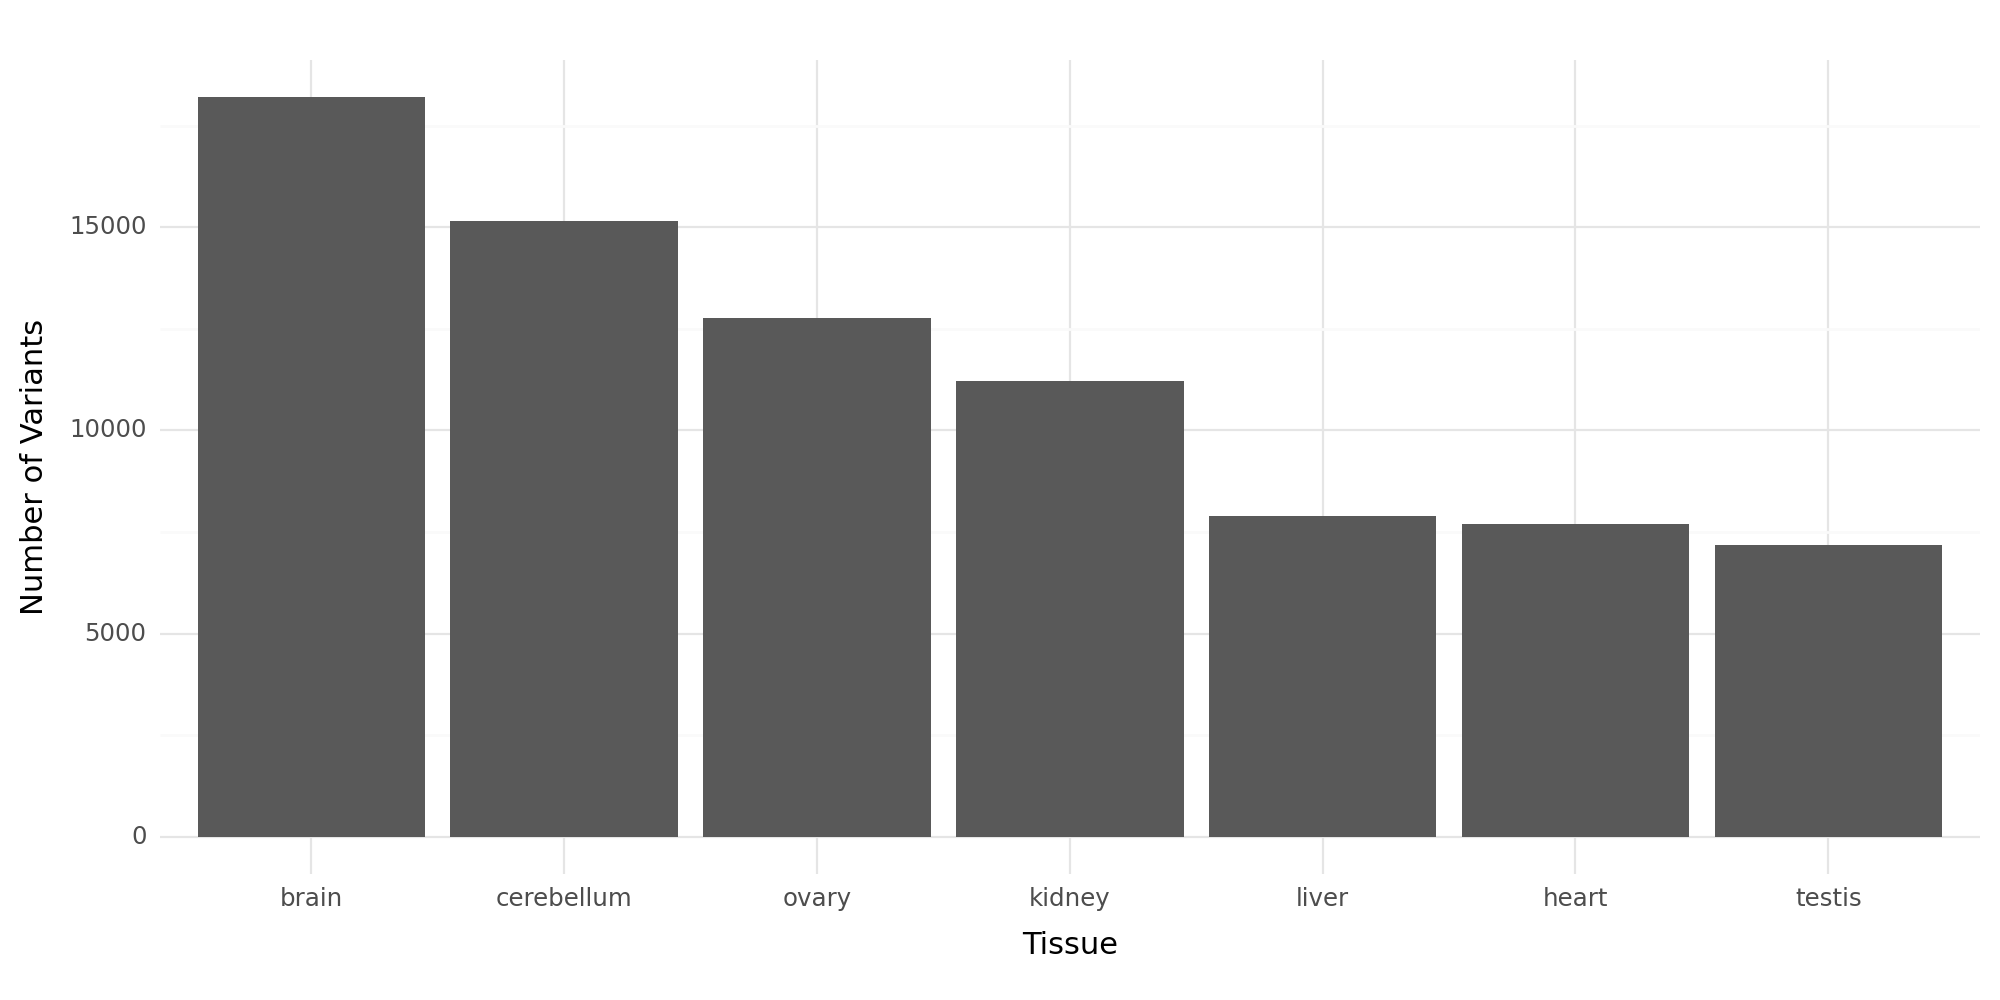

<Figure Size: (1000 x 500)>

In [134]:
df_num_vars['tissue'] = pd.Categorical(df_num_vars['tissue'], categories=df_num_vars.sort_values('num_vars', ascending=False)['tissue'], ordered=True)

(
    ggplot(df_num_vars[df_num_vars['tissue'] != 'all_tissues'], aes(x='tissue', y='num_vars')) +
    geom_bar(stat='identity') +
    labs(x='Tissue', y='Number of Variants') +
    theme_minimal()
)

In [114]:
df_num_vars.to_csv(os.path.join(SAVE_DIR,  'number_of_variants_high_impact_early_no_impact_adult.csv'), index=False)

In [98]:
df_stats = []
for tissue in tissues:
    df_stats.append(pd.DataFrame(tissue_vars[tissue]).rename(columns={0:'variant', 1: 'gene_id'}))
df_stats = pd.concat(df_stats)

In [101]:
df_stats = df_stats.drop_duplicates()

In [103]:
df_stats['dev_var'] = True

In [106]:
df_dev_var_genes = df_stats[['gene_id', 'dev_var']].drop_duplicates()

In [109]:
df_loeuf_devAS_vars = df_loeuf_devAS.set_index('gene_id').join(df_dev_var_genes.set_index('gene_id')).reset_index()

In [111]:
df_loeuf_devAS_vars = df_loeuf_devAS_vars.fillna(False)

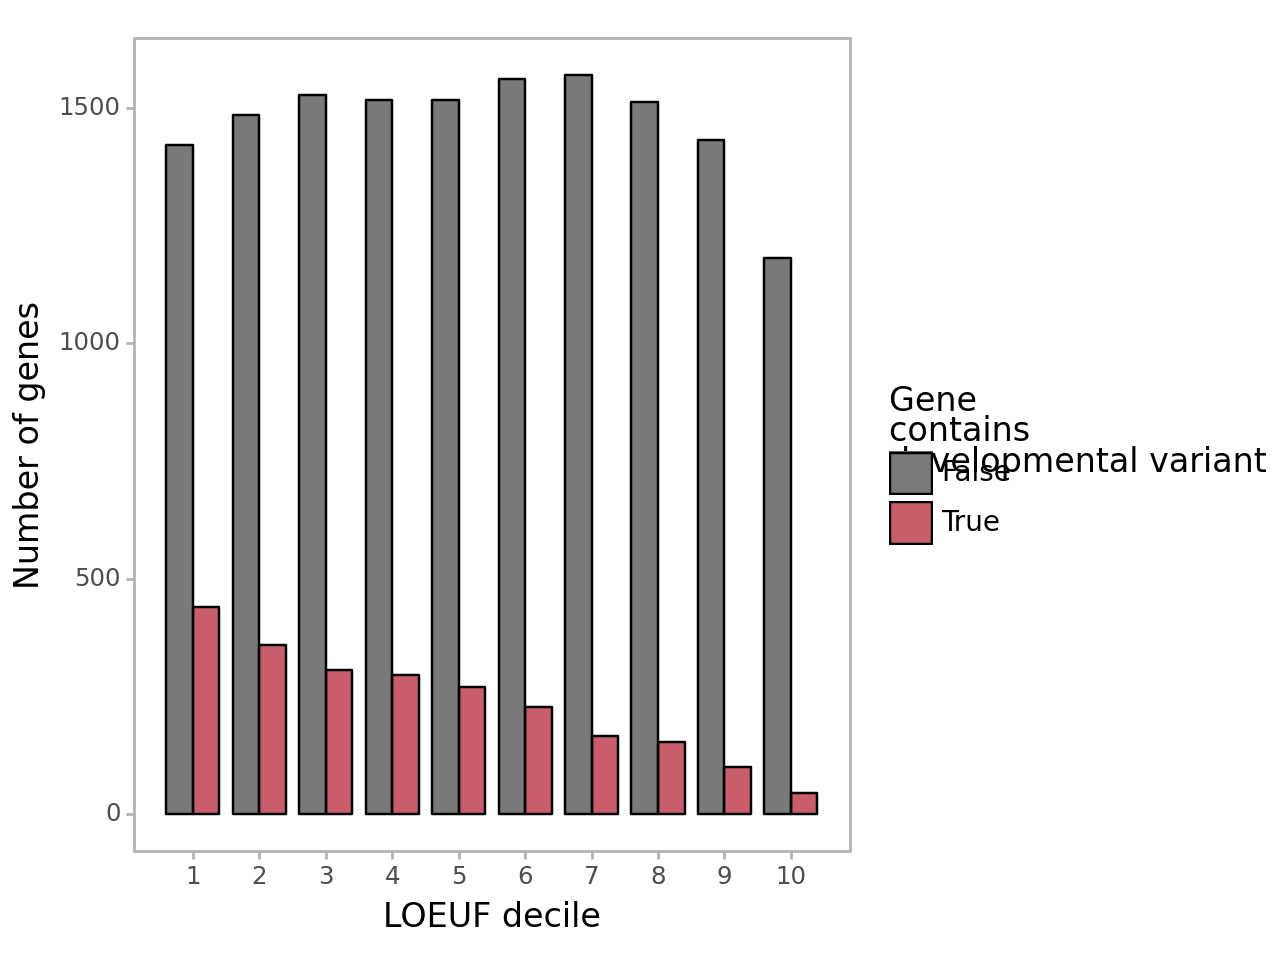

<Figure Size: (640 x 480)>

In [442]:
fontsize=12
(
    ggplot(df_loeuf_devAS_vars, aes(x='LOEUF_decile', fill='dev_var'))
    + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
    + theme_light()
    + labs(
        x="LOEUF decile", 
        y="Number of genes",
        fill='Gene \ncontains \ndevelopmental variant'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
    + theme(
        axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
        axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
        legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
        legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
        panel_grid_major=element_blank(),  # Remove major grid lines
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_background=element_blank(),  # Remove panel background
        plot_background=element_blank(),  # Make the plot background transparent
        legend_background=element_blank()  # Transparent legend background
    )
)

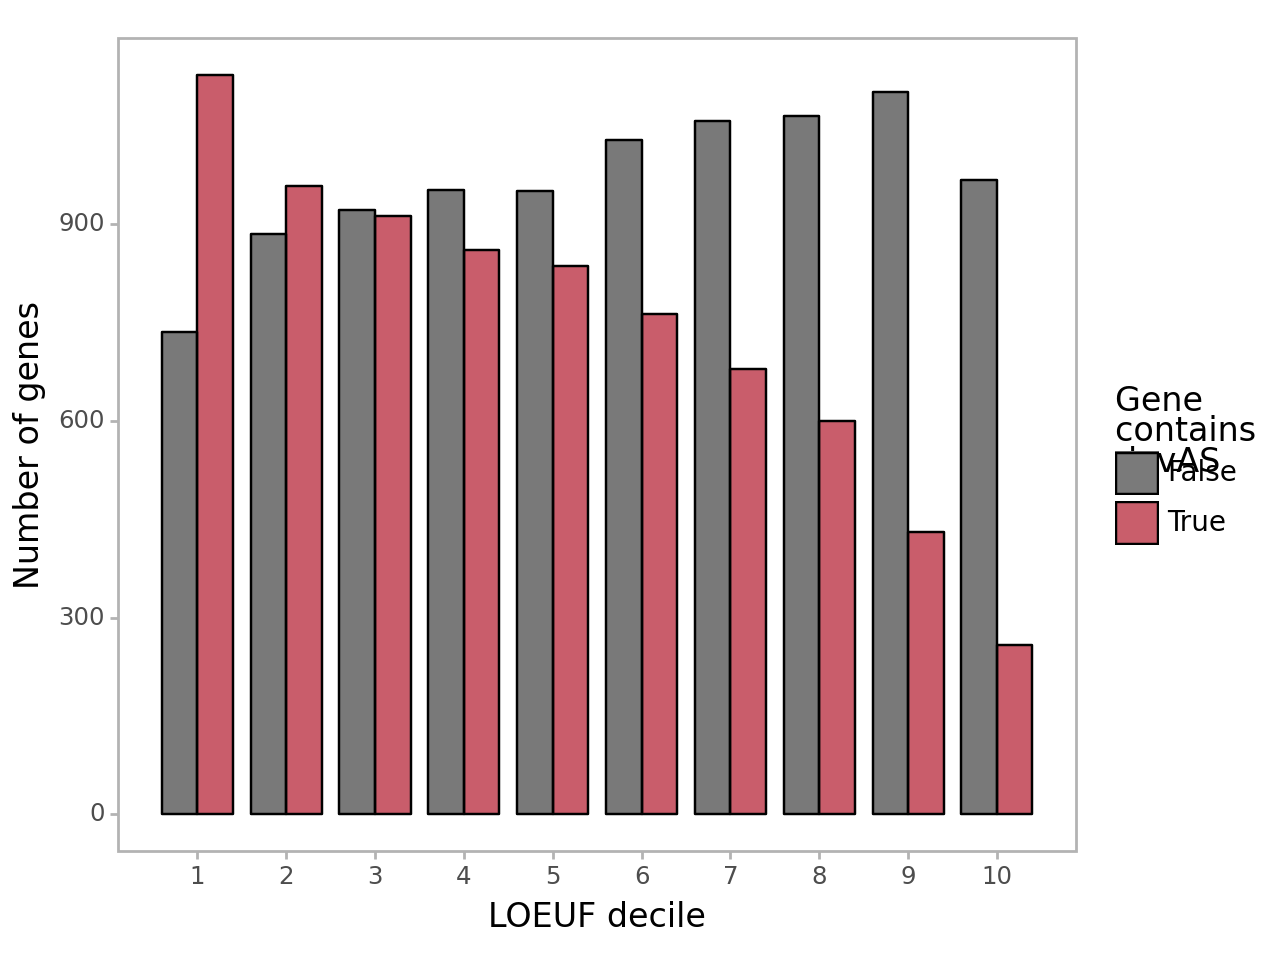

<Figure Size: (640 x 480)>

In [443]:
fontsize=12
(
    ggplot(df_loeuf_devAS_vars, aes(x='LOEUF_decile', fill='devAS'))
    + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
    + theme_light()
    + labs(
        x="LOEUF decile", 
        y="Number of genes",
        fill='Gene \ncontains \ndevAS'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
    + theme(
        axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
        axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
        legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
        legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
        panel_grid_major=element_blank(),  # Remove major grid lines
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_background=element_blank(),  # Remove panel background
        plot_background=element_blank(),  # Make the plot background transparent
        legend_background=element_blank()  # Transparent legend background
    )
)

In [445]:
df_loeuf_devAS_vars.to_csv(os.path.join(SAVE_DIR, 'LOUEF_devAS_distribution.csv'), index=False)

In [121]:
LOEUF_decile_stat_test(df_loeuf_devAS, col='devAS')

devAS       False  True 
lof_group               
intolerant   2541   2998
tolerant     3134   1289
Odds ratio: 2.87
P-value: 1.52e-140


In [123]:
LOEUF_decile_stat_test(df_loeuf_devAS_vars, col='dev_var')

dev_var     False  True 
lof_group               
intolerant   4432   1107
tolerant     4125    298
Odds ratio: 3.46
P-value: 8.11e-85


In [130]:
df = df_loeuf_devAS_vars.copy()
# col = 'devAS'
col = 'dev_var'

# Prepare results
results = []
for decile in range(1, 11):
    df_dec = df[df['LOEUF_decile'] == decile]
    df_other = df[df['LOEUF_decile'] != decile]

    a = df_dec[col].sum()               # devAS in this decile
    b = len(df_dec) - a                     # no devAS in this decile
    c = df_other[col].sum()             # devAS in other deciles
    d = len(df_other) - c                   # no devAS in other deciles

    table = [[a, b], [c, d]]
    or_val, p = fisher_exact(table)

    results.append({'LOEUF_decile': decile, 'odds_ratio': or_val, 'p_value': p})

df_or = pd.DataFrame(results)
df_or

,LOEUF_decile,odds_ratio,p_value
0,1,2.144201,5.104307e-34
1,2,1.595522,1.268991e-12
2,3,1.288307,1.967344e-04
3,4,1.239829,1.961705e-03
4,5,1.122049,1.032875e-01
5,6,0.902761,1.809107e-01
6,7,0.636590,2.339827e-08
7,8,0.603988,1.620614e-09
8,9,0.409533,4.342757e-21
9,10,0.222283,1.061264e-34


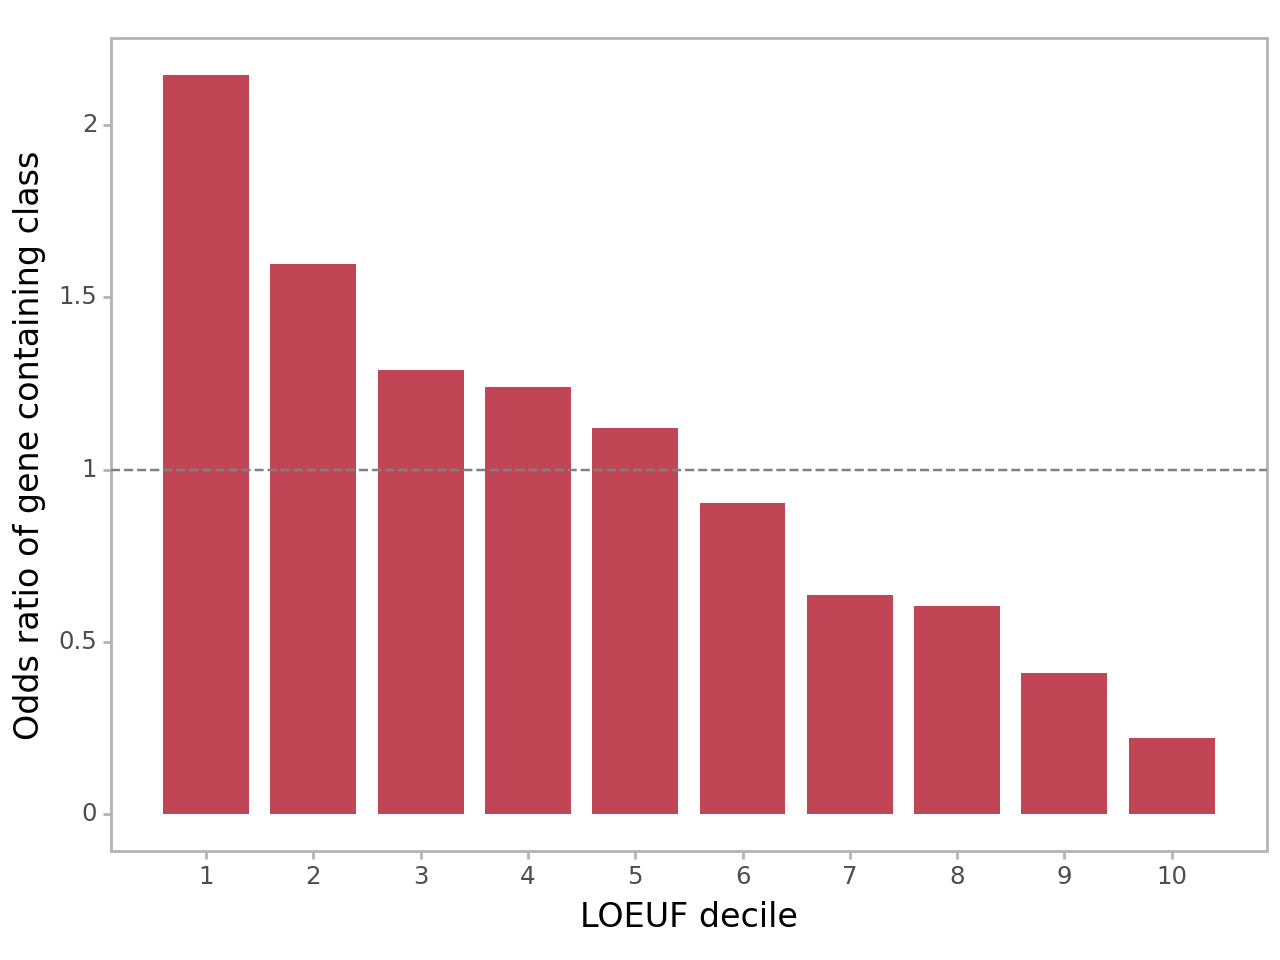

<Figure Size: (640 x 480)>

In [446]:
from plotnine import *

fontsize = 12
(
    ggplot(df_or, aes(x='LOEUF_decile', y='odds_ratio'))
    + geom_bar(stat='identity', fill='#b2182b', alpha=0.8, width=0.8)
    + geom_hline(yintercept=1, linetype='dashed', color='gray')
    + labs(
        x='LOEUF decile',
        y=f'Odds ratio of gene containing {col}'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + theme_light()
    + theme(
        axis_title_x=element_text(size=fontsize),
        axis_title_y=element_text(size=fontsize),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        plot_background=element_blank()
    )
)
